In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import process_data
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [2]:
data_raw = process_data.get_data()

In [3]:
# Split the data into a training and a testing set
split_date = '2024-09-15'
data_train = data_raw.loc[data_raw.index <= split_date].reset_index()
data_test = data_raw.loc[data_raw.index > split_date].reset_index()
    
# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
# data_train.plot(x="Start time", y="Energy_Wh", ax=ax1, color='blue', label='Training Data', figsize=(10, 5), kind="scatter")
# data_test.plot(x="Start time", y="Energy_Wh", ax=ax2, color='red', label='Test Data', figsize=(10, 5), kind="scatter")

#plt.show()


07:30:24 - cmdstanpy - INFO - Chain [1] start processing
07:30:25 - cmdstanpy - INFO - Chain [1] done processing


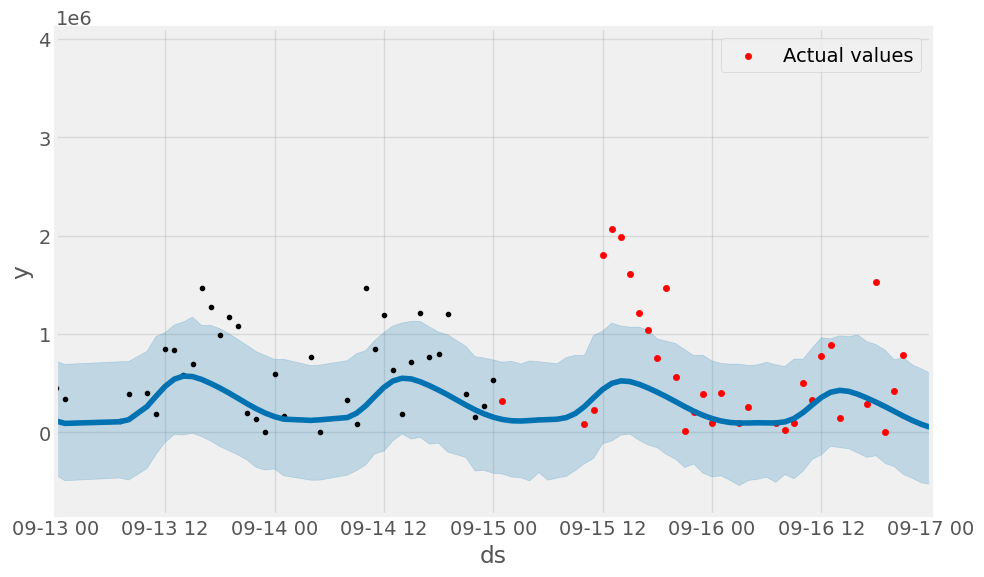

In [4]:
# Train prophet model on training data
data_train_prophet = data_train.rename(columns={'Start time':'ds','Energy_Wh':'y'})
#data_train_prophet = data_train_prophet[data_train_prophet['ds'] > '2024-08-10']
days_prediction = 4
data_test_prophet = data_test.reset_index().rename(columns={'Start time':'ds','Energy_Wh':'y'})
m = Prophet(changepoint_prior_scale=0.05, seasonality_mode='multiplicative').fit(data_train_prophet)
future = m.make_future_dataframe(periods=days_prediction * 24, freq='H')
fcst = m.predict(future)

# Plot prophet model, training data as well as the actual values
fig = m.plot(fcst)
fig = data_test_prophet.plot(x = 'ds', y='y',ax=fig.gca(), kind='scatter', color='red', label='Actual values')
plt.xlim(datetime(2024,9,13),datetime(2024,9,17))
plt.show()



In [5]:
# Calculate predicted price indices

def linear_scale_value(y, ymin, ymax, scalemin=0.8, scalemax=1.2):
    return (y - ymin) / (ymax - ymin) * (scalemax - scalemin) + scalemin

price_index_by_hour = fcst[['ds', 'yhat']]
price_index_by_hour = price_index_by_hour.set_index('ds')

# Create window with minimum and maximum predicted values last 24 hours for indexing
price_index_minmax_window = price_index_by_hour.copy().rolling('24h', center=True)
price_index_by_hour['ymin'] = price_index_minmax_window.min()
price_index_by_hour['ymax'] = price_index_minmax_window.max()
price_index_by_hour = price_index_by_hour.reset_index()
price_index_by_hour = price_index_by_hour[price_index_by_hour['ds'] > split_date]

# add column based on calculation of other columns
price_index_by_hour['linear_pred_price_index'] = price_index_by_hour.apply(lambda r: linear_scale_value(r['yhat'], r['ymin'], r['ymax']), axis=1)
price_index_by_hour = price_index_by_hour[['ds', 'linear_pred_price_index']]

In [6]:
# Join price_index_by_hour with test data
predicted_earnings = price_index_by_hour.merge(data_test_prophet, on='ds', how='inner')

# Calc predicted revenue
predicted_earnings['predicted_revenue'] = predicted_earnings['y'] * predicted_earnings['linear_pred_price_index']
predicted_earnings['revenue'] = predicted_earnings['y']
# Create day sum
predicted_earnings = predicted_earnings.groupby(predicted_earnings['ds'].dt.date).aggregate({'predicted_revenue': 'sum', 'revenue': 'sum'})
predicted_earnings['pct_diff'] = (predicted_earnings['predicted_revenue'] - predicted_earnings['revenue']) / predicted_earnings['revenue']
predicted_earnings['pct_diff'] = predicted_earnings['pct_diff'].apply(lambda x: round(x, 2))
# Skip last element since that is not actually calculated
display(predicted_earnings[:-1])

,predicted_revenue,revenue,pct_diff
ds,,,
2024-09-15,1.537132e+07,1.373436e+07,0.12
2024-09-16,6.914522e+06,6.724872e+06,0.03
2024-09-17,5.933388e+06,5.430876e+06,0.09
2024-09-18,1.074522e+07,1.021147e+07,0.05
